<a href="https://colab.research.google.com/github/hiro-zeroth/F1-Driver-Clustering/blob/main/f1_driver_clustering_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup and Data Loading

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rohanrao/formula-1-world-championship-1950-2020
!unzip formula-1-world-championship-1950-2020.zip -d f1data

import pandas as pd

Mounted at /content/drive


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020
License(s): CC0-1.0
  0% 0.00/6.28M [00:00<?, ?B/s]
100% 6.28M/6.28M [00:00<00:00, 746MB/s]
Archive:  formula-1-world-championship-1950-2020.zip
  inflating: f1data/circuits.csv     
  inflating: f1data/constructor_results.csv  
  inflating: f1data/constructor_standings.csv  
  inflating: f1data/constructors.csv  
  inflating: f1data/driver_standings.csv  
  inflating: f1data/drivers.csv      
  inflating: f1data/lap_times.csv    
  inflating: f1data/pit_stops.csv    
  inflating: f1data/qualifying.csv   
  inflating: f1data/races.csv        
  inflating: f1data/results.csv      
  inflating: f1data/seasons.csv      
  inflating: f1data/sprint_results.csv  
  inflating: f1data/status.csv       


In [ ]:
results = pd.read_csv("f1data/results.csv")
drivers = pd.read_csv("f1data/drivers.csv")
races = pd.read_csv("f1data/races.csv")
constructors = pd.read_csv("f1data/constructors.csv")

In [ ]:
print("Results shape:", results.shape)
print("Drivers shape:", drivers.shape)
print("Races shape:", races.shape)
print(results.head())

Results shape: (26759, 18)
Drivers shape: (861, 9)
Races shape: (1125, 18)
   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   
3         4      18         4              4      5    11        4   
4         5      18         5              1     23     3        5   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   
2            3              3     6.0    58       +8.163      5698779   
3            4              4     5.0    58      +17.181      5707797   
4            5              5     4.0    58      +18.014      5708630   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0   

Data Preparation

In [ ]:
df = results.merge(races[["raceId", "year"]], on="raceId", how="left")

In [ ]:
# Merge df with drivers to get driver surname
df = df.merge(drivers[["driverId", "surname"]], on="driverId", how="left")

hamilton = df[df["surname"] == "Hamilton"]
print("Hamilton total races:", hamilton.shape[0])

Hamilton total races: 361


Feature Engineering

Races per season (for normalization)

In [ ]:
season_races = df.groupby("year")["raceId"].nunique().reset_index()
season_races.rename(columns={"raceId": "total_races"}, inplace=True)
df = df.merge(season_races, on="year", how="left")

Driver performance per season

In [ ]:
driver_season = df.groupby(["driverId", "year"]).agg({
    "points": "sum",
    "raceId": "nunique",
    "positionOrder": lambda x: (x == 1).sum(),  # wins
}).reset_index()
driver_season.rename(columns={"positionOrder": "wins"}, inplace=True)

Normalize points by season leader (to adjust to different eras)

In [ ]:
season_max_points = driver_season.groupby("year")["points"].transform("max")
driver_season["points_pct"] = driver_season["points"] / season_max_points
driver_season["win_pct"] = driver_season["wins"] / driver_season["raceId"]

Podiums per season

In [ ]:
df["podium"] = df["positionOrder"] <= 3
podium_season = df.groupby(["driverId", "year"])["podium"].mean().reset_index()
driver_season = driver_season.merge(podium_season, on=["driverId", "year"])
driver_season.rename(columns={"podium": "podium_pct"}, inplace=True)

Career averages (era-adjusted)

In [ ]:
driver_career = driver_season.groupby("driverId").agg({
    "points_pct": "mean",
    "win_pct": "mean",
    "podium_pct": "mean",
}).reset_index()

driver_career = driver_career.merge(
    drivers[["driverId", "surname", "forename"]],
    on="driverId",
    how="left"
)


Copy to driver_perf for extended stats

In [ ]:
driver_perf = driver_career.copy()

DNF stats

In [ ]:
dnf_mask = results["positionText"].isin(["R", "DNF", "DSQ", "W", "DQ"])
driver_perf["dnfs"] = (
    results[dnf_mask]
    .groupby("driverId")["raceId"]
    .nunique()
).fillna(0)
driver_perf["dnf_pct"] = driver_perf["dnfs"] / results.groupby("driverId")["raceId"].nunique()

Wins

In [ ]:
driver_perf["wins"] = (
    results[results["positionOrder"] == 1]
    .groupby("driverId")["raceId"]
    .nunique()
).fillna(0)
driver_perf["win_pct_raw"] = driver_perf["wins"] / results.groupby("driverId")["raceId"].nunique()

Avg grid position

In [ ]:
driver_perf["avg_grid"] = results.groupby("driverId")["grid"].mean()

Constructors driven

In [ ]:
driver_perf["teams_driven"] = results.groupby("driverId")["constructorId"].nunique()

Clustering

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

features = driver_career[["points_pct", "win_pct", "podium_pct"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

Elbow Method

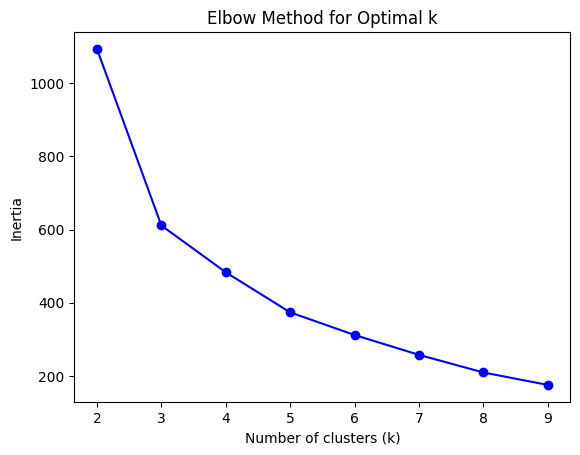

In [ ]:
inertia = []
K = range(2, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(K, inertia, "bo-")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

Final mode (k=4)

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
driver_perf["cluster"] = kmeans.fit_predict(X_scaled)

Evaluation

In [ ]:
sil_score = silhouette_score(X_scaled, driver_perf["cluster"])
print("Silhouette Score:", sil_score)

Silhouette Score: 0.8037981516630018


Visualization

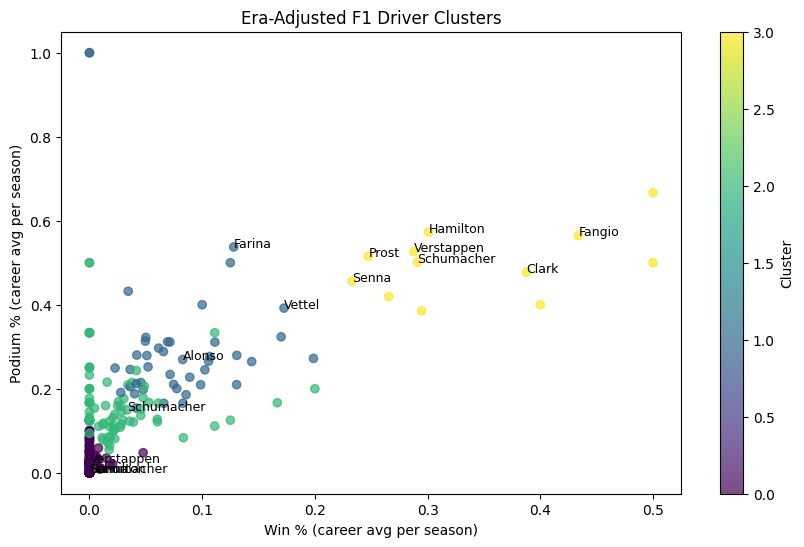

In [ ]:
plt.figure(figsize=(10,6))
scatter = plt.scatter(
    driver_perf["win_pct"],
    driver_perf["podium_pct"],
    c=driver_perf["cluster"],
    cmap="viridis",
    alpha=0.7
)

for _, row in driver_perf.iterrows():
    if row["surname"] in ["Hamilton", "Verstappen", "Schumacher", "Senna", "Fangio", "Alonso","Prost","Vettel","Farina", "Clark"]:
        plt.text(row["win_pct"], row["podium_pct"], row["surname"], fontsize=9)

plt.xlabel("Win % (career avg per season)")
plt.ylabel("Podium % (career avg per season)")
plt.title("Era-Adjusted F1 Driver Clusters")
plt.colorbar(scatter, label="Cluster")
plt.show()


Insights

In [ ]:
print(driver_perf.groupby("cluster")[["points_pct", "win_pct", "podium_pct", "dnf_pct"]].mean())

for name in ["Hamilton", "Verstappen", "Schumacher", "Senna", "Fangio", "Alonso","Prost","Clark"]:
    sample = df[df["surname"] == name]["driverId"].unique()
    if len(sample) > 0:
        d_id = sample[0]
        cluster = driver_perf.loc[driver_perf["driverId"] == d_id, "cluster"].values[0]
        print(f"{name} is in Cluster {cluster}")

         points_pct   win_pct  podium_pct   dnf_pct
cluster                                            
0          0.010541  0.000233    0.004452  0.522932
1          0.363547  0.077664    0.304418  0.409890
2          0.151604  0.025749    0.163575  0.436575
3          0.582553  0.345118    0.498744  0.544401
Hamilton is in Cluster 3
Verstappen is in Cluster 0
Schumacher is in Cluster 2
Senna is in Cluster 3
Fangio is in Cluster 3
Alonso is in Cluster 1
Prost is in Cluster 3
Clark is in Cluster 3
